<h2> <center> Deep Convolutional Generative Adversarial Networks </center> </h2>

## GAN description : 

Basically two neural networks are competiting: a generator creates a picture, and the discriminator is trying to detect it as fake or not. We are injecting in the discrimator real picture. After a while, generator starts generating pictures close to original dataset.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "./gan.png",width=700, height=450)

## Let's start :

Here are the general steps I understood : 
    1. Generate few pictures with generator. This is gonna be pure random at first
    2. Get the generated pictures and add same numbers from training set. From the created batch of picture, train the generator to discern fake from real picture.
    3. After few steps of training, Discrimator is fixed and we create new picture in the generator, and we submit them to the discriminator. We optimize then the generator to make its pictures as real as possible.
    4. Repeat last 3 steps, until created pictures are good quality (i.e state of equilibrium where Generator produces picture that discriminator can not discern from real picture, while discriminator one time over two find a fake picture).

Architecture guidelines for stable DCGANs :
1. Replace any pooling layers with strided convolutions ( discriminator ) and fractional-strided convolutions ( generator ).
2. Use batch normalization in both the generator and the dicriminator. 
3. Remove fully connected hidden layers for deeper architectures.
4. Use ReLU activation in the generator for all layers except for the output which uses tanh.
5. Use LeakyReLU activation in the discriminator for all layers. 

Minimax theorem that started the game theory states that for two players in a zero-sum game the minimax solution is the same as the Nash equilibrium.

In simpler terms, when two players (D and G) are competing against each other (zero-sum game), and both play optimally assuming that their opponent is optimally (minimax strategy), the outcome is predetermined and none of the players can change it (Nash equilibrium).
So, for our networks, it means that if we train them long enough, the Generator will learn how to sample from true “distribution,” meaning that it will start generating real life-like images, and the Discriminator will not be able to tell fake ones from genuine ones.

### Different imports :

In [2]:
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.backend import resize_images
from keras.initializers import RandomNormal
import tqdm
import os
import glob
from keras.optimizers import Adam,RMSprop
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


### Loading Data :

Let's get our data :

In [3]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [4]:
num_train, num_test = x_train.shape[0], x_test.shape[0]
M = num_train + num_test
x_all = np.zeros((M, 28, 28))
x_all[:num_train, :, :] = x_train
x_all[num_train:, :, :] = x_test

In [5]:
x_final = np.zeros((M, 64, 64))

for index, image in enumerate(x_all):
    x_final[index,:,:] = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)

### The generator : 

In [6]:
Image(url= "./gen_architecture.png",width=700, height=450)

MNIST dataset is composed of monochrome 28x28 pixel images, so the desired shape for our input layer is [batch_size, 28, 28, 1]. 

To calculate output shape of deconv layer: With <b> padding = Same: H = H1 x stride </b> if <b> padding = Valid
H = (H1-1) x stride + HF (H = output size, H1 = input size, HF = height of filter) </b>

On the last layer ( conv 4 on the picture ), we will have just one filter since we are dealing with monochrome pictures. 

In [7]:
def generator():
    
    filter_size=[1024,512,256,128,1]
    weight_init = RandomNormal(mean=0.0, stddev=0.02) # This is what was suggested in the paper.
    
    model = Sequential()
    
    model.add(Dense(input_dim=100, output_dim=filter_size[0]*4*4, kernel_initializer=weight_init)) 
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Reshape((4, 4, 1024)))  # Here the shape is (batch_size, 4, 4, 1024)
    #----------------------------------------------------------------------------------------------------
    
    model.add(Conv2DTranspose(filters=filter_size[0], kernel_size=(5, 5), strides=(1,1), padding='same',kernel_initializer=weight_init))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9)) #Output is shape (batch_size, 4, 4, 1024)
    #----------------------------------------------------------------------------------------------------
    
    model.add(Conv2DTranspose(filters=filter_size[1], kernel_size=(5, 5), strides=(2,2), padding='same',kernel_initializer=weight_init))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9)) #Output is shape (batch_size, 8, 8, 512)
    #----------------------------------------------------------------------------------------------------

    # 2nd layer :
    model.add(Conv2DTranspose(filters=filter_size[2], kernel_size=(5, 5), strides=(2,2), padding='same', kernel_initializer=weight_init))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9)) #Output is shape (batch_size, 16, 16, 256)
    #----------------------------------------------------------------------------------------------------

    # 3rd layer :
    model.add(Conv2DTranspose(filters=filter_size[3], kernel_size=(5, 5), strides=(2,2), padding='same', kernel_initializer=weight_init))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9)) #Output is shape (batch_size, 32, 32, 128)
    #----------------------------------------------------------------------------------------------------
    
    # 5th layer :
    model.add(Conv2DTranspose(filters=filter_size[4], kernel_size=(5, 5), strides=(2,2), padding='same', kernel_initializer=weight_init))
    model.add(Activation('tanh'))
    #Output is shape (batch_size, 64, 64, 1)
    #----------------------------------------------------------------------------------------------------

    return model


Let's test our generator and check the kind of pictures it generates :

3/3 [==============================] - 1s 264ms/step
(3, 64, 64, 1)


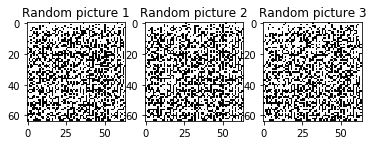

In [8]:
BATCH_SIZE = 3

Z = np.random.uniform(-1, 1, (BATCH_SIZE, 100))

gen = generator()
gen.compile(loss='binary_crossentropy', optimizer="SGD")
generated_images = gen.predict(Z, verbose=1)

print(generated_images.shape)
plt.subplot(1, 3, 1)
plt.imshow((generated_images[0].reshape((64,64))*255).astype(np.uint8), cmap=plt.cm.Greys )
plt.title('Random picture 1')

plt.subplot(1, 3, 2)
plt.imshow((generated_images[1].reshape((64,64))*255).astype(np.uint8), cmap=plt.cm.Greys )
plt.title('Random picture 2')
    
plt.subplot(1, 3, 3)
plt.imshow((generated_images[2].reshape((64,64))*255).astype(np.uint8), cmap=plt.cm.Greys  )
plt.title('Random picture 3')

plt.show() 

### The discriminator : 

Basically, this is the opposite of our generator. From a 64x64 picture, we will use the convnet to output a number between 0 and 1 ( sigmoid ? ). 

In [9]:
Image(url= "./discriminator.png",width=700, height=450)

As a reminder, the ouput size of a convolutional layer is $\frac{n+2p-f}{s}+1 $ (n= input shape, p = padding, s = stride, f= filter size). 
Padding shape is:
* "Valid" : n-f+1
* "Same" : $p=\frac{f-1}{2}$ ; n + 2p -f +1

There is no common rules regarding, the filter size, just a 2^n size. If I keep same kernel size as the generator, I will end up with 2x2x1024 as output of the last conv layer. This is maybe not good, but let's try.

In [10]:
def discriminator():
    
    filter_size=[128,256,512,1024]
    weight_init = RandomNormal(mean=0.0, stddev=0.02) # As suggested in paper
    
    in_shape = (64, 64, 1)
    model = Sequential()
    
    model.add(Conv2D(filters=filter_size[0], kernel_size=(5, 5), strides=(2,2), padding='same',input_shape=in_shape,kernel_initializer=weight_init))
    model.add(LeakyReLU(alpha=0.01))
    # ouput size 32 x 32 x 128
    #----------------------------------------------------------------------------------------------------
    
    model.add(Conv2D(filters=filter_size[0], kernel_size=(5, 5), strides=(2,2), padding='same',kernel_initializer=weight_init))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.9)) 
    #ouput size 16 x 16 x 128
    #----------------------------------------------------------------------------------------------------

    model.add(Conv2D(filters=filter_size[1], kernel_size=(5, 5), strides=(2,2), padding='same',kernel_initializer=weight_init))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.9)) 
    # output size is 8 x 8 x 256
    #----------------------------------------------------------------------------------------------------
    
    model.add(Conv2D(filters=filter_size[2], kernel_size=(5, 5), strides=(2,2), padding='same',kernel_initializer=weight_init))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.9)) 
    # output size is 4 x 4 x 512
    #----------------------------------------------------------------------------------------------------

    model.add(Conv2D(filters=filter_size[3], kernel_size=(5, 5), strides=(2,2), padding='same',kernel_initializer=weight_init))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.9)) 
    # output size is 2 x 2 x 1024
    #----------------------------------------------------------------------------------------------------

    #Before we connect the layer, however, we'll flatten our feature map (conv_4) to shape [batch_size, features],
    #so that our tensor has only two dimensions:
    model.add(Flatten()) # output is 4096
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [11]:
in1 = np.random.uniform(-1.0,1.0,[1, 64,64])
random_picture = np.reshape(in1, (1, 64, 64, -1))

discri = discriminator()
discri.compile(loss='binary_crossentropy',optimizer='adam') 
return_label = discri.predict(random_picture, verbose=1)
print(return_label)

1/1 [==============================] - 0s 181ms/step
[[0.49980718]]


PERFECT ! 

## Train the model :

Now, we enter the real GAN mechanism. As a reminder we currently have a generator and a disriminator. The question is, how to handle the complete GAN process ? Here are the main steps:

1. Generate a batch of fake images with the Generator
2. Train the discriminator mixing the batch of fake image + a same number of real image. We also add the label <b>0=fake, 1=real</b>. Optimize the weight of Discriminator network.
3. Generate picture with the generator, infere them in the discriminator network and improve the genrator network.


#### Generate a batch of images :

In [12]:
batch_size = 128

Z = np.random.uniform(-1, 1, (batch_size, 100))
gen = generator()
gen.compile(loss='binary_crossentropy', optimizer="adam")
generated_images = gen.predict(Z, verbose=1)

print(generated_images.shape)

128/128 [==============================] - 0s 3ms/step
(128, 64, 64, 1)


In [13]:
Z.shape

(128, 100)

#### Train the discriminator :

First, we are going to train the discriminator:
* when receiving real images, the discriminator should learn to compute high values (near 1), meaning that it is confident the input images are real
* when receiving fake images, it should compute low values (near 0), meaning it is confident the input images are not real


Prepare the Mnist dataset to feed the batch:

In [14]:
def data_tensor(X):
    '''
    numpy_data: (M, 28, 28), values in range [0, 255]
    returns: tensor of images shaped [M, 64, 64, 1], with values in range [-1, 1]
    '''
    
    X = np.expand_dims(X, axis=3) # add a dimension for number of chanel, here gray images, so only one chanel of 255 possibilities

    # The data is currently in a range [0, 255].
    # Transform data to have a range [-1, 1].
    # We do this to match the range of tanh, the activation on the generator's output layer.
    X = np.array(X)
    X = X / 128.
    X = X - 1.
    return X

#### Combined models : 

To train the generator, we need to know the discriminator loss, so let's build a combined model which is just the genrator and then the denominator

In [15]:
def stacked_model(g, d):
    model = Sequential()
    model.add(g)
    d.trainable = False
    model.add(d)
    return model

Notice that we’re setting the discriminator’s training attribute to False before building the model. This means that for this model we will not be updating the weights of the discriminator during backpropagation. We will freeze these weights and only move the generator weights with the stack. The discriminator will be trained separately. Let's compile the models with the correct optimizer:

In [16]:
gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
disc_optimizer = Adam(lr=0.0002, beta_1=0.5)
# As suggedted in the paper.

gen = generator()
discri = discriminator()

discri.compile(loss='binary_crossentropy', optimizer=disc_optimizer, metrics=['accuracy'])
gen.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

combined = stacked_model(gen,discri)
combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

Notice that beta_1 = 0.5. This is a recommendation from the original DCGAN paper that we’ve carried forward and also had success with. A learning rate of 0.0002 is a good place to start, also recommended by DCGAN paper.

In [17]:
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 64, 64, 1)         45150721  
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 17629825  
Total params: 62,780,546
Trainable params: 45,114,113
Non-trainable params: 17,666,433
_________________________________________________________________


#### Train the model on a simple batch :

Just to simply understand. Let's train it first on only one batch (X) of 64 real picture and 64 fake pictures and their corresponding labels.

In [18]:
batch_size = 64

# creating 64 fake images and 64 real images
noise = np.random.normal(0, 1, (batch_size, 100))

fake_images = gen.predict(noise)
fake_labels = np.zeros((64, 1))

image_batch = x_final[0:64]
real_images = data_tensor(image_batch)

real_labels = np.ones((64, 1))

print(real_images.shape)

(64, 64, 64, 1)


In [19]:
# Train the discriminator (real classified as ones and generated as zeros)
d_loss_real = discri.train_on_batch(real_images, real_labels)
d_loss_fake = discri.train_on_batch(fake_images, fake_labels)

Discriminator model has updated its weights, thanks to the real images and fake images. The model is theoritically better at discerning fake from real images.

In [20]:
d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
d_loss

array([2.4475303, 0.34375  ], dtype=float32)

In [21]:
noise = np.random.normal(0, 1, (batch_size, 100))

# Train the generator with fake images, pretending this is real ones.
g_loss = combined.train_on_batch(noise, np.ones((64, 1)))

# Plot the progress
print("[D loss: %f, acc.: %.2f%%] [G loss: %f]" %( d_loss[0], 100 * d_loss[1], g_loss))

[D loss: 2.447530, acc.: 34.38%] [G loss: 1.729178]


In [22]:
noise.shape

(64, 100)

#### Let's go far and undrestand the theory behind this loss :

The discriminator’s loss function is the cross entropy loss function. To understand this, let’s suppose we’re doing some binary classification with some trainable function D that we wish to optimize, where D
D indicates the estimated probability of some data point $x_{i}$ being in the first class. To get the predicted probability of being in the second class, we just do 1-D($x_{i}$).

The cross entropy between two distributions, which we’ll call p and q, is defined as:

$H(p,q) = - \sum(p_{i} log(q_{i})$

To apply this loss function to the current binary classification task, we define the true distribution as $P[y_{i}=0]=1$ if $y_{i}=0$ and $P[y_{i}=1]=1$ if $y_{i}=1$

Thus, for one data point x1 and its label, we get the following loss function:

$H(x1,y1) = -y1.log(D(x1)-(1-y1)log(1-D(x1))$

Let’s look at the above function. Notice that only one of the two terms is going to be zero, depending on the value of y1 , which makes sense since it’s defining a distribution which is either [0,1] or [1,0].


Have a look here https://danieltakeshi.github.io/2017/03/05/understanding-generative-adversarial-networks/

#### Full model training :

In [23]:
import scipy.misc
def save_imgs(generator, epoch, batch):
    
    r, c = 5, 5
    
    noise = np.random.normal(0, 1, (r * c, 100))
    
    gen_imgs = generator.predict(noise)
    
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
            
    fig.savefig("images/mnist_%d_%d"%(epoch, batch))

[D loss: 2.447530, acc.: 34.38%] [G loss: 0.986761]
Epoch 0 Batch 0/546 [D loss: 0.520396, acc.: 77.34%] [G loss: 6.464296]
Epoch 0 Batch 1/546 [D loss: 0.004551, acc.: 100.00%] [G loss: 9.395754]
Epoch 0 Batch 2/546 [D loss: 0.005355, acc.: 100.00%] [G loss: 6.696475]
Epoch 0 Batch 3/546 [D loss: 0.193463, acc.: 91.41%] [G loss: 10.640100]
Epoch 0 Batch 4/546 [D loss: 0.000008, acc.: 100.00%] [G loss: 14.395582]
Epoch 0 Batch 5/546 [D loss: 0.000018, acc.: 100.00%] [G loss: 12.969676]
Epoch 0 Batch 6/546 [D loss: 0.000509, acc.: 100.00%] [G loss: 8.995777]
Epoch 0 Batch 7/546 [D loss: 0.042582, acc.: 99.22%] [G loss: 10.742600]
Epoch 0 Batch 8/546 [D loss: 0.000086, acc.: 100.00%] [G loss: 12.188820]
Epoch 0 Batch 9/546 [D loss: 0.000618, acc.: 100.00%] [G loss: 9.896397]
Epoch 0 Batch 10/546 [D loss: 0.007378, acc.: 100.00%] [G loss: 7.716825]
Epoch 0 Batch 11/546 [D loss: 0.009900, acc.: 100.00%] [G loss: 8.525950]
Epoch 0 Batch 12/546 [D loss: 0.001600, acc.: 100.00%] [G loss: 8.43

Epoch 0 Batch 110/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 111/546 [D loss: 0.000001, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 112/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 113/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 114/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 115/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 116/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 117/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 118/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 119/546 [D loss: 0.000004, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 120/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 121/546 [D loss: 0.000001, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 122/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batc

Epoch 0 Batch 218/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 219/546 [D loss: 0.000001, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 220/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 221/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 222/546 [D loss: 0.000014, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 223/546 [D loss: 0.000042, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 224/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 225/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 226/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 227/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 228/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 229/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.084335]
Epoch 0 Batch 230/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.076866]
Epoch 0 Batc

Epoch 0 Batch 326/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 327/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 328/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 329/546 [D loss: 0.000001, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 330/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 331/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 332/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 333/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 334/546 [D loss: 0.000001, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 335/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 336/546 [D loss: 0.000007, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 337/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 338/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batc

Epoch 0 Batch 434/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 435/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 436/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 437/546 [D loss: 0.000001, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 438/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 439/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 440/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 441/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 442/546 [D loss: 0.000001, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 443/546 [D loss: 0.000001, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 444/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 445/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batch 446/546 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
Epoch 0 Batc

Epoch 0 Batch 543/546 [D loss: 0.000017, acc.: 100.00%] [G loss: 15.135942]
Epoch 0 Batch 544/546 [D loss: 0.000674, acc.: 100.00%] [G loss: 14.840054]
Epoch 0 Batch 545/546 [D loss: 0.000667, acc.: 100.00%] [G loss: 13.679047]
Epoch 1 Batch 0/546 [D loss: 0.056930, acc.: 96.88%] [G loss: 15.724542]
Epoch 1 Batch 1/546 [D loss: 0.000266, acc.: 100.00%] [G loss: 15.680506]
Epoch 1 Batch 2/546 [D loss: 0.000002, acc.: 100.00%] [G loss: 15.679897]
Epoch 1 Batch 3/546 [D loss: 0.000016, acc.: 100.00%] [G loss: 15.748842]
Epoch 1 Batch 4/546 [D loss: 0.000013, acc.: 100.00%] [G loss: 14.470828]
Epoch 1 Batch 5/546 [D loss: 0.000938, acc.: 100.00%] [G loss: 14.160582]
Epoch 1 Batch 6/546 [D loss: 0.028755, acc.: 99.22%] [G loss: 13.758316]
Epoch 1 Batch 7/546 [D loss: 0.006472, acc.: 100.00%] [G loss: 12.836789]
Epoch 1 Batch 8/546 [D loss: 0.003399, acc.: 100.00%] [G loss: 11.655310]
Epoch 1 Batch 9/546 [D loss: 0.091891, acc.: 97.66%] [G loss: 15.562277]
Epoch 1 Batch 10/546 [D loss: 8.684

Epoch 1 Batch 109/546 [D loss: 0.917863, acc.: 28.12%] [G loss: 2.996984]
Epoch 1 Batch 110/546 [D loss: 0.265888, acc.: 99.22%] [G loss: 2.925477]
Epoch 1 Batch 111/546 [D loss: 0.334298, acc.: 97.66%] [G loss: 3.630751]
Epoch 1 Batch 112/546 [D loss: 0.930869, acc.: 43.75%] [G loss: 5.511878]
Epoch 1 Batch 113/546 [D loss: 1.429217, acc.: 19.53%] [G loss: 1.863394]
Epoch 1 Batch 114/546 [D loss: 0.214612, acc.: 95.31%] [G loss: 3.562337]
Epoch 1 Batch 115/546 [D loss: 0.421945, acc.: 83.59%] [G loss: 2.678062]
Epoch 1 Batch 116/546 [D loss: 0.393003, acc.: 92.19%] [G loss: 3.778227]
Epoch 1 Batch 117/546 [D loss: 0.287232, acc.: 94.53%] [G loss: 2.371054]
Epoch 1 Batch 118/546 [D loss: 0.121266, acc.: 100.00%] [G loss: 3.433681]
Epoch 1 Batch 119/546 [D loss: 0.246041, acc.: 97.66%] [G loss: 3.937182]
Epoch 1 Batch 120/546 [D loss: 0.090192, acc.: 100.00%] [G loss: 2.970904]
Epoch 1 Batch 121/546 [D loss: 0.218182, acc.: 96.09%] [G loss: 5.512859]
Epoch 1 Batch 122/546 [D loss: 3.517

Epoch 1 Batch 220/546 [D loss: 0.083338, acc.: 99.22%] [G loss: 4.656906]
Epoch 1 Batch 221/546 [D loss: 0.350809, acc.: 86.72%] [G loss: 2.519003]
Epoch 1 Batch 222/546 [D loss: 0.162594, acc.: 100.00%] [G loss: 2.695024]
Epoch 1 Batch 223/546 [D loss: 0.138916, acc.: 100.00%] [G loss: 3.170635]
Epoch 1 Batch 224/546 [D loss: 0.266666, acc.: 98.44%] [G loss: 2.647161]
Epoch 1 Batch 225/546 [D loss: 0.061282, acc.: 100.00%] [G loss: 4.419781]
Epoch 1 Batch 226/546 [D loss: 0.078689, acc.: 100.00%] [G loss: 3.425431]
Epoch 1 Batch 227/546 [D loss: 0.057783, acc.: 100.00%] [G loss: 3.284582]
Epoch 1 Batch 228/546 [D loss: 0.062522, acc.: 100.00%] [G loss: 3.401561]
Epoch 1 Batch 229/546 [D loss: 0.017114, acc.: 100.00%] [G loss: 4.109961]
Epoch 1 Batch 230/546 [D loss: 0.033785, acc.: 100.00%] [G loss: 2.849362]
Epoch 1 Batch 231/546 [D loss: 0.038707, acc.: 100.00%] [G loss: 3.138604]
Epoch 1 Batch 232/546 [D loss: 0.365408, acc.: 94.53%] [G loss: 4.188302]
Epoch 1 Batch 233/546 [D loss

Epoch 1 Batch 330/546 [D loss: 0.036659, acc.: 100.00%] [G loss: 3.464217]
Epoch 1 Batch 331/546 [D loss: 0.056065, acc.: 100.00%] [G loss: 4.066237]
Epoch 1 Batch 332/546 [D loss: 0.120549, acc.: 100.00%] [G loss: 5.442855]
Epoch 1 Batch 333/546 [D loss: 2.679103, acc.: 6.25%] [G loss: 6.001184]
Epoch 1 Batch 334/546 [D loss: 0.105266, acc.: 100.00%] [G loss: 7.343719]
Epoch 1 Batch 335/546 [D loss: 0.942811, acc.: 40.62%] [G loss: 1.793652]
Epoch 1 Batch 336/546 [D loss: 0.371269, acc.: 76.56%] [G loss: 5.679830]
Epoch 1 Batch 337/546 [D loss: 0.480520, acc.: 64.06%] [G loss: 2.471793]
Epoch 1 Batch 338/546 [D loss: 0.140039, acc.: 99.22%] [G loss: 3.752653]
Epoch 1 Batch 339/546 [D loss: 0.039801, acc.: 100.00%] [G loss: 4.794547]
Epoch 1 Batch 340/546 [D loss: 0.818149, acc.: 51.56%] [G loss: 6.156711]
Epoch 1 Batch 341/546 [D loss: 0.435952, acc.: 78.91%] [G loss: 2.590995]
Epoch 1 Batch 342/546 [D loss: 0.258797, acc.: 89.84%] [G loss: 5.904584]
Epoch 1 Batch 343/546 [D loss: 0.8

Epoch 1 Batch 440/546 [D loss: 0.673484, acc.: 62.50%] [G loss: 5.361091]
Epoch 1 Batch 441/546 [D loss: 1.902063, acc.: 0.78%] [G loss: 2.580960]
Epoch 1 Batch 442/546 [D loss: 0.073863, acc.: 100.00%] [G loss: 3.571610]
Epoch 1 Batch 443/546 [D loss: 0.557440, acc.: 75.78%] [G loss: 1.766900]
Epoch 1 Batch 444/546 [D loss: 0.549609, acc.: 60.16%] [G loss: 3.972398]
Epoch 1 Batch 445/546 [D loss: 0.529404, acc.: 68.75%] [G loss: 2.373901]
Epoch 1 Batch 446/546 [D loss: 0.206133, acc.: 100.00%] [G loss: 2.604528]
Epoch 1 Batch 447/546 [D loss: 0.421264, acc.: 88.28%] [G loss: 3.646955]
Epoch 1 Batch 448/546 [D loss: 0.174395, acc.: 100.00%] [G loss: 3.029101]
Epoch 1 Batch 449/546 [D loss: 0.276252, acc.: 100.00%] [G loss: 2.194472]
Epoch 1 Batch 450/546 [D loss: 0.111964, acc.: 100.00%] [G loss: 3.636049]
Epoch 1 Batch 451/546 [D loss: 0.220247, acc.: 100.00%] [G loss: 2.946373]
Epoch 1 Batch 452/546 [D loss: 0.166976, acc.: 100.00%] [G loss: 3.246379]
Epoch 1 Batch 453/546 [D loss: 0

Epoch 2 Batch 4/546 [D loss: 0.019532, acc.: 100.00%] [G loss: 4.177521]
Epoch 2 Batch 5/546 [D loss: 0.045227, acc.: 100.00%] [G loss: 4.265005]
Epoch 2 Batch 6/546 [D loss: 0.125336, acc.: 100.00%] [G loss: 4.294129]
Epoch 2 Batch 7/546 [D loss: 0.009430, acc.: 100.00%] [G loss: 4.891146]
Epoch 2 Batch 8/546 [D loss: 0.024252, acc.: 100.00%] [G loss: 5.501041]
Epoch 2 Batch 9/546 [D loss: 0.014994, acc.: 100.00%] [G loss: 4.521406]
Epoch 2 Batch 10/546 [D loss: 0.007648, acc.: 100.00%] [G loss: 4.201292]
Epoch 2 Batch 11/546 [D loss: 0.039685, acc.: 100.00%] [G loss: 4.065519]
Epoch 2 Batch 12/546 [D loss: 0.024412, acc.: 100.00%] [G loss: 4.121526]
Epoch 2 Batch 13/546 [D loss: 0.035463, acc.: 100.00%] [G loss: 4.674299]
Epoch 2 Batch 14/546 [D loss: 0.023816, acc.: 100.00%] [G loss: 4.636254]
Epoch 2 Batch 15/546 [D loss: 0.008549, acc.: 100.00%] [G loss: 4.763237]
Epoch 2 Batch 16/546 [D loss: 0.035809, acc.: 100.00%] [G loss: 3.772614]
Epoch 2 Batch 17/546 [D loss: 0.331040, acc.

Epoch 2 Batch 116/546 [D loss: 0.083656, acc.: 100.00%] [G loss: 2.812197]
Epoch 2 Batch 117/546 [D loss: 0.124923, acc.: 100.00%] [G loss: 3.244383]
Epoch 2 Batch 118/546 [D loss: 0.036840, acc.: 100.00%] [G loss: 3.307871]
Epoch 2 Batch 119/546 [D loss: 0.122692, acc.: 100.00%] [G loss: 3.597336]
Epoch 2 Batch 120/546 [D loss: 0.051217, acc.: 100.00%] [G loss: 4.046867]
Epoch 2 Batch 121/546 [D loss: 0.055115, acc.: 100.00%] [G loss: 3.414080]
Epoch 2 Batch 122/546 [D loss: 0.093391, acc.: 100.00%] [G loss: 3.061440]
Epoch 2 Batch 123/546 [D loss: 0.715900, acc.: 53.91%] [G loss: 7.098660]
Epoch 2 Batch 124/546 [D loss: 2.164743, acc.: 50.00%] [G loss: 3.117423]
Epoch 2 Batch 125/546 [D loss: 0.251291, acc.: 96.88%] [G loss: 2.117885]
Epoch 2 Batch 126/546 [D loss: 0.202873, acc.: 98.44%] [G loss: 2.327178]
Epoch 2 Batch 127/546 [D loss: 0.106387, acc.: 100.00%] [G loss: 3.304821]
Epoch 2 Batch 128/546 [D loss: 0.573368, acc.: 69.53%] [G loss: 3.828281]
Epoch 2 Batch 129/546 [D loss:

Epoch 2 Batch 226/546 [D loss: 0.051701, acc.: 100.00%] [G loss: 4.675664]
Epoch 2 Batch 227/546 [D loss: 0.037819, acc.: 100.00%] [G loss: 5.003369]
Epoch 2 Batch 228/546 [D loss: 0.017988, acc.: 100.00%] [G loss: 3.629905]
Epoch 2 Batch 229/546 [D loss: 0.010488, acc.: 100.00%] [G loss: 3.901160]
Epoch 2 Batch 230/546 [D loss: 0.024256, acc.: 100.00%] [G loss: 3.592855]
Epoch 2 Batch 231/546 [D loss: 0.033854, acc.: 100.00%] [G loss: 3.388450]
Epoch 2 Batch 232/546 [D loss: 0.069148, acc.: 100.00%] [G loss: 2.696461]
Epoch 2 Batch 233/546 [D loss: 0.067831, acc.: 100.00%] [G loss: 3.619057]
Epoch 2 Batch 234/546 [D loss: 0.097861, acc.: 99.22%] [G loss: 4.802551]
Epoch 2 Batch 235/546 [D loss: 0.031666, acc.: 100.00%] [G loss: 5.342470]
Epoch 2 Batch 236/546 [D loss: 0.030542, acc.: 100.00%] [G loss: 4.293567]
Epoch 2 Batch 237/546 [D loss: 0.042789, acc.: 100.00%] [G loss: 3.382644]
Epoch 2 Batch 238/546 [D loss: 0.035125, acc.: 100.00%] [G loss: 3.577692]
Epoch 2 Batch 239/546 [D l

Epoch 2 Batch 336/546 [D loss: 0.139871, acc.: 99.22%] [G loss: 3.378427]
Epoch 2 Batch 337/546 [D loss: 0.502274, acc.: 78.91%] [G loss: 2.015662]
Epoch 2 Batch 338/546 [D loss: 0.159780, acc.: 97.66%] [G loss: 3.509775]
Epoch 2 Batch 339/546 [D loss: 0.170917, acc.: 100.00%] [G loss: 3.565626]
Epoch 2 Batch 340/546 [D loss: 0.395660, acc.: 94.53%] [G loss: 2.209065]
Epoch 2 Batch 341/546 [D loss: 0.103986, acc.: 100.00%] [G loss: 4.067993]
Epoch 2 Batch 342/546 [D loss: 0.046702, acc.: 100.00%] [G loss: 3.145328]
Epoch 2 Batch 343/546 [D loss: 0.109112, acc.: 100.00%] [G loss: 2.654519]
Epoch 2 Batch 344/546 [D loss: 0.021443, acc.: 100.00%] [G loss: 3.176253]
Epoch 2 Batch 345/546 [D loss: 0.037235, acc.: 100.00%] [G loss: 4.224639]
Epoch 2 Batch 346/546 [D loss: 0.047616, acc.: 100.00%] [G loss: 3.892256]
Epoch 2 Batch 347/546 [D loss: 0.595832, acc.: 61.72%] [G loss: 5.121178]
Epoch 2 Batch 348/546 [D loss: 2.129618, acc.: 1.56%] [G loss: 3.771680]
Epoch 2 Batch 349/546 [D loss: 0

Epoch 2 Batch 446/546 [D loss: 0.047061, acc.: 100.00%] [G loss: 4.553310]
Epoch 2 Batch 447/546 [D loss: 0.435054, acc.: 84.38%] [G loss: 4.691984]
Epoch 2 Batch 448/546 [D loss: 0.041595, acc.: 100.00%] [G loss: 5.691055]
Epoch 2 Batch 449/546 [D loss: 0.107986, acc.: 100.00%] [G loss: 2.066966]
Epoch 2 Batch 450/546 [D loss: 0.126248, acc.: 100.00%] [G loss: 5.324799]
Epoch 2 Batch 451/546 [D loss: 0.793167, acc.: 53.12%] [G loss: 5.354846]
Epoch 2 Batch 452/546 [D loss: 0.102811, acc.: 98.44%] [G loss: 6.066741]
Epoch 2 Batch 453/546 [D loss: 0.080568, acc.: 99.22%] [G loss: 4.839215]
Epoch 2 Batch 454/546 [D loss: 0.032245, acc.: 100.00%] [G loss: 3.653850]
Epoch 2 Batch 455/546 [D loss: 0.039972, acc.: 100.00%] [G loss: 3.889297]
Epoch 2 Batch 456/546 [D loss: 0.031979, acc.: 100.00%] [G loss: 4.562366]
Epoch 2 Batch 457/546 [D loss: 0.090776, acc.: 99.22%] [G loss: 2.965453]
Epoch 2 Batch 458/546 [D loss: 0.042420, acc.: 100.00%] [G loss: 3.276224]
Epoch 2 Batch 459/546 [D loss:

Epoch 3 Batch 10/546 [D loss: 0.011890, acc.: 100.00%] [G loss: 4.802374]
Epoch 3 Batch 11/546 [D loss: 0.007671, acc.: 100.00%] [G loss: 5.023064]
Epoch 3 Batch 12/546 [D loss: 0.021411, acc.: 100.00%] [G loss: 4.665409]
Epoch 3 Batch 13/546 [D loss: 0.010134, acc.: 100.00%] [G loss: 4.770011]
Epoch 3 Batch 14/546 [D loss: 0.004298, acc.: 100.00%] [G loss: 5.289883]
Epoch 3 Batch 15/546 [D loss: 0.006159, acc.: 100.00%] [G loss: 4.541922]
Epoch 3 Batch 16/546 [D loss: 0.076481, acc.: 100.00%] [G loss: 5.970144]
Epoch 3 Batch 17/546 [D loss: 0.018602, acc.: 100.00%] [G loss: 5.670396]
Epoch 3 Batch 18/546 [D loss: 0.024869, acc.: 100.00%] [G loss: 3.920021]
Epoch 3 Batch 19/546 [D loss: 0.025016, acc.: 100.00%] [G loss: 4.034910]
Epoch 3 Batch 20/546 [D loss: 0.006594, acc.: 100.00%] [G loss: 5.227607]
Epoch 3 Batch 21/546 [D loss: 0.008960, acc.: 100.00%] [G loss: 4.239678]
Epoch 3 Batch 22/546 [D loss: 0.007344, acc.: 100.00%] [G loss: 4.654991]
Epoch 3 Batch 23/546 [D loss: 0.007614

Epoch 3 Batch 121/546 [D loss: 0.003801, acc.: 100.00%] [G loss: 6.691152]
Epoch 3 Batch 122/546 [D loss: 0.003471, acc.: 100.00%] [G loss: 6.768776]
Epoch 3 Batch 123/546 [D loss: 0.003003, acc.: 100.00%] [G loss: 6.124429]
Epoch 3 Batch 124/546 [D loss: 0.003186, acc.: 100.00%] [G loss: 5.412362]
Epoch 3 Batch 125/546 [D loss: 0.005795, acc.: 100.00%] [G loss: 6.287198]
Epoch 3 Batch 126/546 [D loss: 0.002625, acc.: 100.00%] [G loss: 5.547371]
Epoch 3 Batch 127/546 [D loss: 0.001695, acc.: 100.00%] [G loss: 5.937572]
Epoch 3 Batch 128/546 [D loss: 0.005055, acc.: 100.00%] [G loss: 5.349434]
Epoch 3 Batch 129/546 [D loss: 0.002142, acc.: 100.00%] [G loss: 7.064055]
Epoch 3 Batch 130/546 [D loss: 0.001672, acc.: 100.00%] [G loss: 6.433527]
Epoch 3 Batch 131/546 [D loss: 0.005894, acc.: 100.00%] [G loss: 5.461113]
Epoch 3 Batch 132/546 [D loss: 2.165126, acc.: 50.00%] [G loss: 16.118095]
Epoch 3 Batch 133/546 [D loss: 7.887831, acc.: 50.00%] [G loss: 13.596437]
Epoch 3 Batch 134/546 [D 

Epoch 3 Batch 231/546 [D loss: 0.088151, acc.: 99.22%] [G loss: 3.887542]
Epoch 3 Batch 232/546 [D loss: 0.343820, acc.: 94.53%] [G loss: 5.034865]
Epoch 3 Batch 233/546 [D loss: 0.389595, acc.: 89.84%] [G loss: 3.854324]
Epoch 3 Batch 234/546 [D loss: 0.178860, acc.: 96.88%] [G loss: 5.967378]
Epoch 3 Batch 235/546 [D loss: 0.143084, acc.: 100.00%] [G loss: 3.431859]
Epoch 3 Batch 236/546 [D loss: 0.244064, acc.: 91.41%] [G loss: 6.933372]
Epoch 3 Batch 237/546 [D loss: 2.223431, acc.: 0.00%] [G loss: 4.378479]
Epoch 3 Batch 238/546 [D loss: 0.086904, acc.: 99.22%] [G loss: 5.556995]
Epoch 3 Batch 239/546 [D loss: 0.304987, acc.: 87.50%] [G loss: 3.195284]
Epoch 3 Batch 240/546 [D loss: 0.201879, acc.: 94.53%] [G loss: 2.553193]
Epoch 3 Batch 241/546 [D loss: 0.203740, acc.: 98.44%] [G loss: 4.051148]
Epoch 3 Batch 242/546 [D loss: 0.159379, acc.: 100.00%] [G loss: 4.228165]
Epoch 3 Batch 243/546 [D loss: 0.137179, acc.: 100.00%] [G loss: 3.124519]
Epoch 3 Batch 244/546 [D loss: 0.337

Epoch 3 Batch 342/546 [D loss: 0.042300, acc.: 100.00%] [G loss: 4.064688]
Epoch 3 Batch 343/546 [D loss: 0.022395, acc.: 100.00%] [G loss: 4.368539]
Epoch 3 Batch 344/546 [D loss: 0.015282, acc.: 100.00%] [G loss: 4.433019]
Epoch 3 Batch 345/546 [D loss: 0.020698, acc.: 100.00%] [G loss: 4.091084]
Epoch 3 Batch 346/546 [D loss: 0.021839, acc.: 100.00%] [G loss: 4.459475]
Epoch 3 Batch 347/546 [D loss: 0.092148, acc.: 100.00%] [G loss: 3.572236]
Epoch 3 Batch 348/546 [D loss: 0.047578, acc.: 100.00%] [G loss: 3.456247]
Epoch 3 Batch 349/546 [D loss: 0.048860, acc.: 100.00%] [G loss: 4.560292]
Epoch 3 Batch 350/546 [D loss: 0.055954, acc.: 100.00%] [G loss: 2.654829]
Epoch 3 Batch 351/546 [D loss: 0.366669, acc.: 79.69%] [G loss: 9.553539]
Epoch 3 Batch 352/546 [D loss: 4.019803, acc.: 50.00%] [G loss: 2.716886]
Epoch 3 Batch 353/546 [D loss: 1.353864, acc.: 25.00%] [G loss: 0.843016]
Epoch 3 Batch 354/546 [D loss: 0.517019, acc.: 75.00%] [G loss: 2.548846]
Epoch 3 Batch 355/546 [D loss

Epoch 3 Batch 452/546 [D loss: 0.049481, acc.: 100.00%] [G loss: 3.744867]
Epoch 3 Batch 453/546 [D loss: 0.028475, acc.: 100.00%] [G loss: 4.241265]
Epoch 3 Batch 454/546 [D loss: 0.061390, acc.: 100.00%] [G loss: 3.983394]
Epoch 3 Batch 455/546 [D loss: 0.149452, acc.: 100.00%] [G loss: 5.391065]
Epoch 3 Batch 456/546 [D loss: 0.010409, acc.: 100.00%] [G loss: 5.905309]
Epoch 3 Batch 457/546 [D loss: 3.380234, acc.: 12.50%] [G loss: 4.511670]
Epoch 3 Batch 458/546 [D loss: 0.296303, acc.: 87.50%] [G loss: 3.791911]
Epoch 3 Batch 459/546 [D loss: 0.489009, acc.: 73.44%] [G loss: 1.478672]
Epoch 3 Batch 460/546 [D loss: 0.108392, acc.: 99.22%] [G loss: 3.019815]
Epoch 3 Batch 461/546 [D loss: 0.024582, acc.: 100.00%] [G loss: 4.152535]
Epoch 3 Batch 462/546 [D loss: 0.057606, acc.: 100.00%] [G loss: 3.882346]
Epoch 3 Batch 463/546 [D loss: 0.046680, acc.: 100.00%] [G loss: 3.841424]
Epoch 3 Batch 464/546 [D loss: 0.076467, acc.: 100.00%] [G loss: 3.451044]
Epoch 3 Batch 465/546 [D loss

Epoch 4 Batch 16/546 [D loss: 0.193520, acc.: 100.00%] [G loss: 2.925690]
Epoch 4 Batch 17/546 [D loss: 0.094494, acc.: 99.22%] [G loss: 3.269284]
Epoch 4 Batch 18/546 [D loss: 0.109409, acc.: 100.00%] [G loss: 3.022613]
Epoch 4 Batch 19/546 [D loss: 0.078738, acc.: 100.00%] [G loss: 2.809744]
Epoch 4 Batch 20/546 [D loss: 0.076270, acc.: 100.00%] [G loss: 3.078020]
Epoch 4 Batch 21/546 [D loss: 0.121861, acc.: 100.00%] [G loss: 3.232660]
Epoch 4 Batch 22/546 [D loss: 0.020047, acc.: 100.00%] [G loss: 3.684288]
Epoch 4 Batch 23/546 [D loss: 0.019234, acc.: 100.00%] [G loss: 3.434876]
Epoch 4 Batch 24/546 [D loss: 0.015511, acc.: 100.00%] [G loss: 3.616464]
Epoch 4 Batch 25/546 [D loss: 0.084994, acc.: 100.00%] [G loss: 3.094741]
Epoch 4 Batch 26/546 [D loss: 0.041517, acc.: 100.00%] [G loss: 3.313029]
Epoch 4 Batch 27/546 [D loss: 0.036179, acc.: 100.00%] [G loss: 3.273391]
Epoch 4 Batch 28/546 [D loss: 0.042935, acc.: 100.00%] [G loss: 3.367258]
Epoch 4 Batch 29/546 [D loss: 0.043101,

KeyboardInterrupt: 

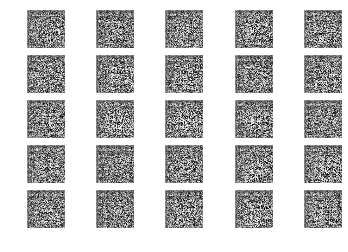

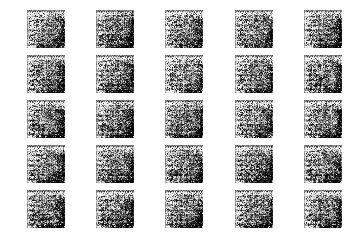

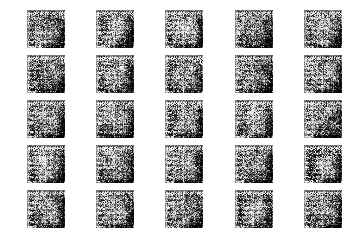

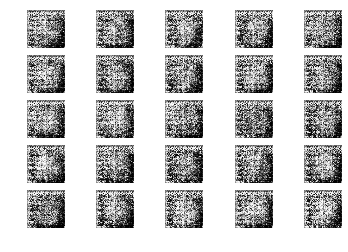

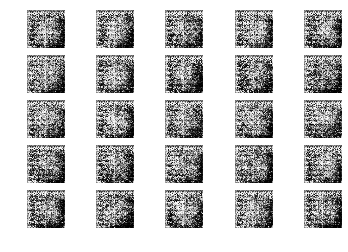

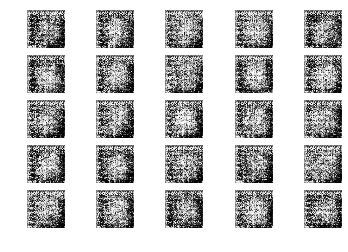

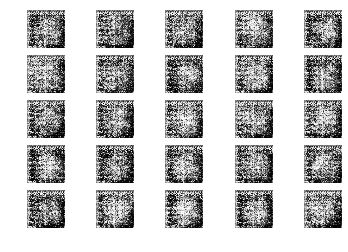

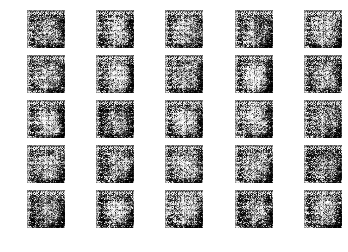

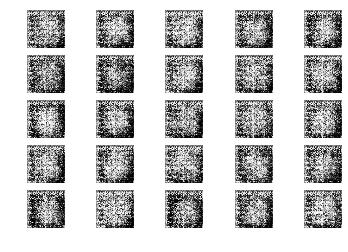

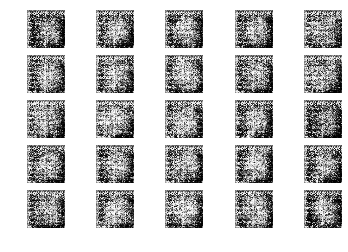

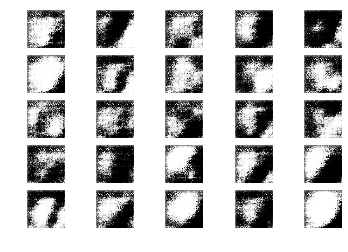

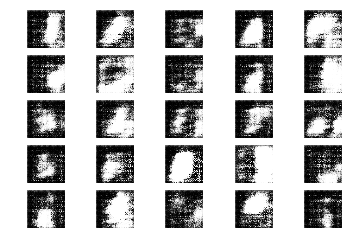

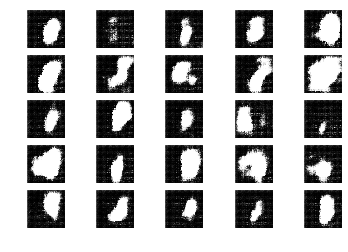

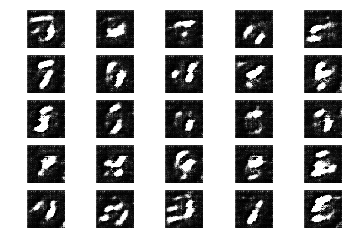

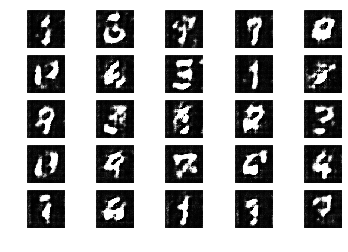

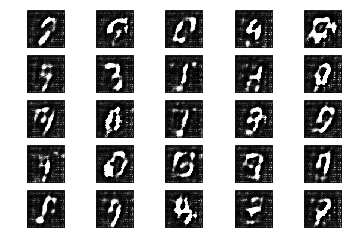

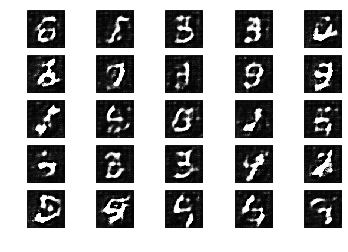

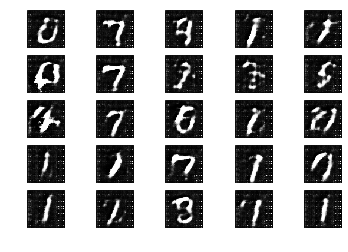

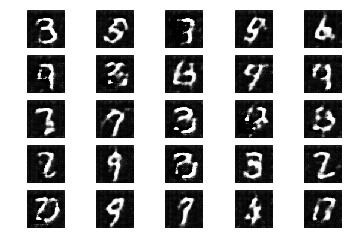

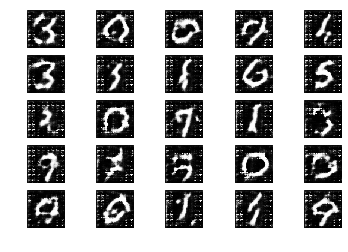

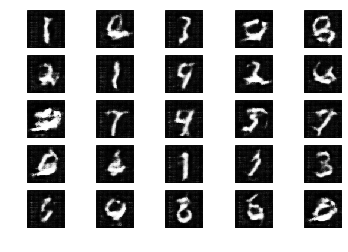

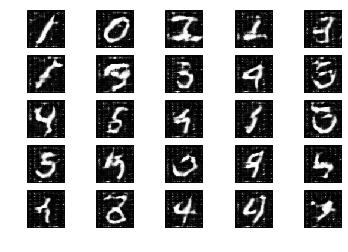

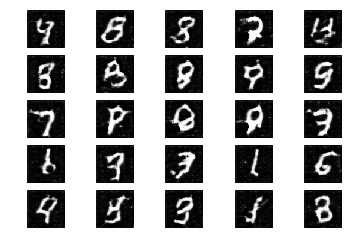

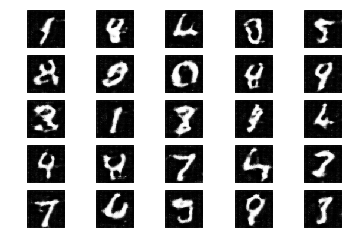

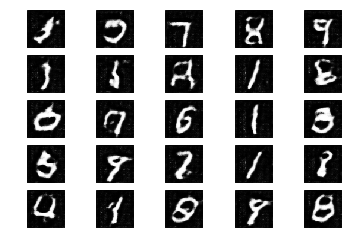

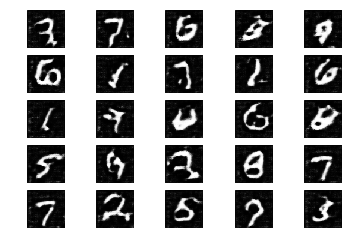

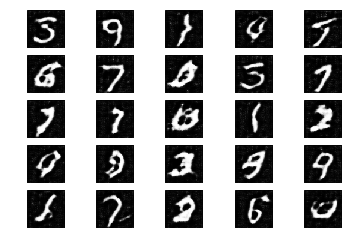

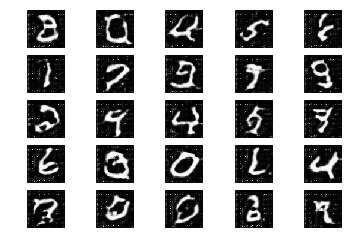

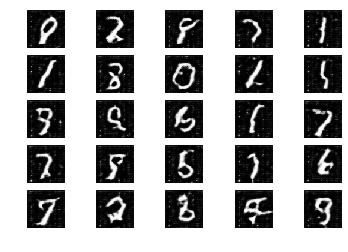

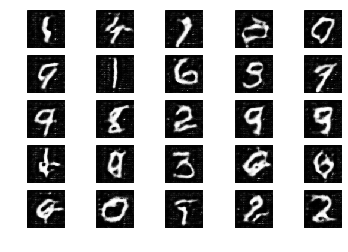

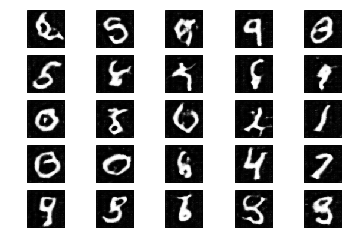

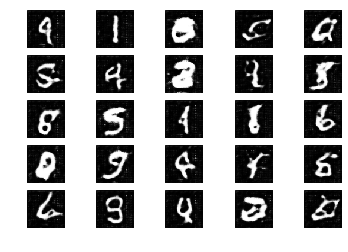

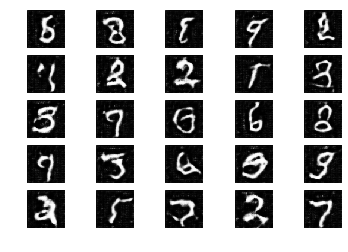

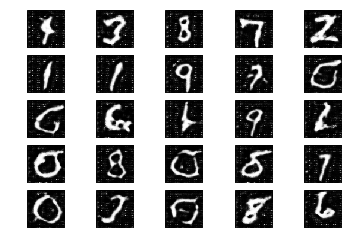

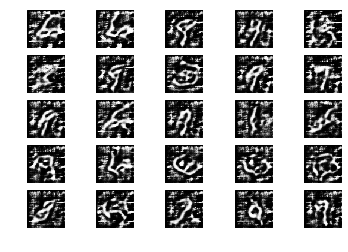

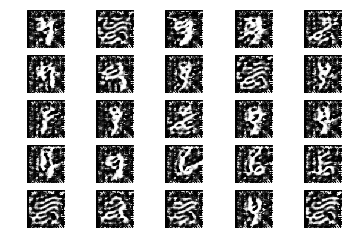

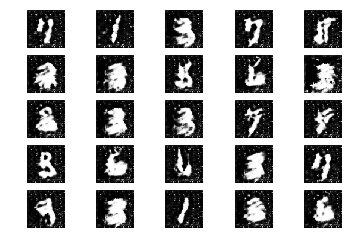

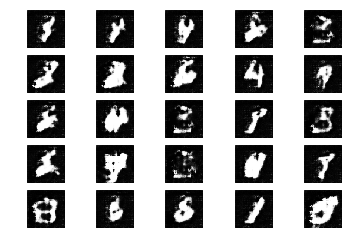

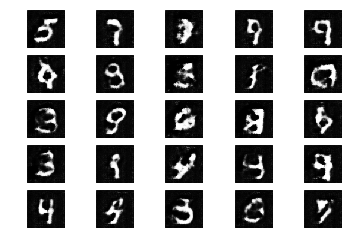

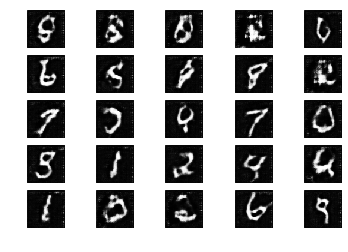

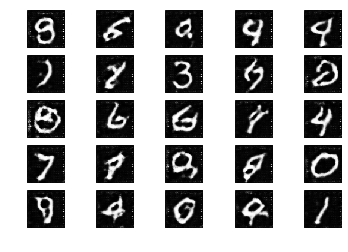

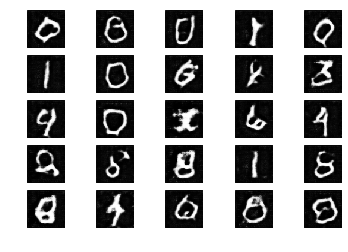

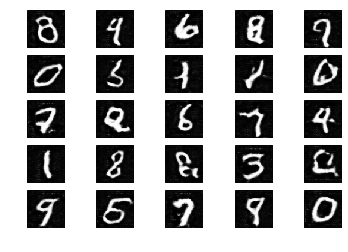

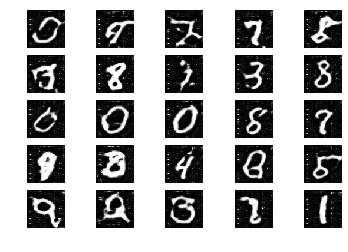

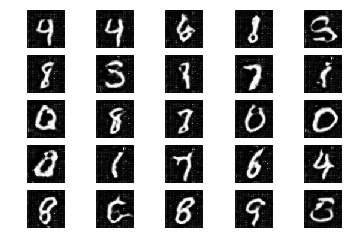

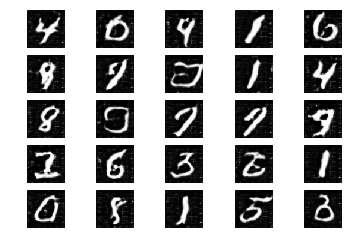

In [24]:
batch_size = 128 # As suggested in the paper.
epochs = 50


x_final = np.array(x_final)
num_examples = x_final.shape[0] 
num_batches = int(num_examples / float(batch_size)) 
half_batch = int(batch_size / 2) 


noise = np.random.normal(0, 1, (64, 100))
# Train the generator with fake images, pretending this is real ones.
g_loss = combined.train_on_batch(noise, np.ones((64, 1)))
# Plot the progress
print("[D loss: %f, acc.: %.2f%%] [G loss: %f]" %( d_loss[0], 100 * d_loss[1], g_loss))


for epoch in range(epochs + 1):
    for batch in range(num_batches):
    # creating the real and fake picture for this batch
        noise = np.random.normal(0, 1, (half_batch, 100))
        
        fake_images = gen.predict(noise)
        fake_labels = np.zeros((half_batch, 1))

        image_batch = x_final[batch*half_batch:batch*half_batch+half_batch]
        real_images=data_tensor(image_batch)
        real_labels = np.ones((half_batch, 1))
        
     # train the discriminator on both real and fake images
        d_loss_real = discri.train_on_batch(real_images, real_labels)
        d_loss_fake = discri.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
    # train the generator
        noise = np.random.normal(0, 1, (half_batch, 100))
        # Train the generator with fake images, pretending this is real ones.
        g_loss = combined.train_on_batch(noise, np.ones((half_batch, 1)))
            
        
        print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))
        if batch % 50 == 0:
            save_imgs(gen, epoch, batch)

GREAT CODE ABOUT DCGAN : https://github.com/jacobgil/keras-dcgan/blob/master/dcgan.py

In [43]:
Image(url= "./animation.gif",width=700, height=450)